# Data Loader

In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import SVHN
from torch.utils.data import Subset, DataLoader

In [67]:
svhn_train = SVHN(root='./data', split='train', download=True)

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

# Step 3: Calculate mean and std across all pixel values
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_samples = len(dataset)

    for i in range(num_samples):
        image, _ = dataset[i]
        mean += torch.mean(transform_to_tensor(image), dim=(1, 2))
        std += torch.std(transform_to_tensor(image), dim=(1, 2))

    mean /= num_samples
    std /= num_samples

    return mean, std

mean, std = calculate_mean_std(svhn_train)
print("Mean:", mean)
print("Std:", std)

Using downloaded and verified file: ./data/train_32x32.mat
Mean: tensor([0.4377, 0.4438, 0.4728])
Std: tensor([0.1201, 0.1231, 0.1052])


In [68]:
batch_size = 16

# Define transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [69]:
# Set random seed for PyTorch and NumPy
torch.manual_seed(42)
np.random.seed(42)

In [70]:
# Define the ratio of labeled to unlabeled data
labeled_ratio = 0.2  # Example: 20% labeled, 80% unlabeled

# Load the entire SVHN dataset
full_trainset = SVHN(root='./data', split='train', download=True, transform=transform)

# Split the dataset into labeled and unlabeled subsets based on the defined ratio
num_labeled = int(len(full_trainset) * labeled_ratio)
indices = np.arange(len(full_trainset))
np.random.shuffle(indices)

labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

# Create labeled and unlabeled datasets
labeled_trainset = Subset(full_trainset, labeled_indices)
unlabeled_trainset = Subset(full_trainset, unlabeled_indices)

labeled_trainloader = DataLoader(labeled_trainset, batch_size=batch_size, shuffle=False)
unlabeled_trainloader = DataLoader(unlabeled_trainset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat


In [71]:
trainloader = labeled_trainloader 

In [72]:
# # Download and load the training dataset
# trainset = SVHN(root='./data', split='train', download=True, transform=transform)
# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [73]:
# Download and load the test dataset
testset = SVHN(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in SVHN dataset
classes = list(range(10))

Using downloaded and verified file: ./data/test_32x32.mat


In [74]:
def imshow(img):
    # Unnormalize the images
    img = img * std[:, None, None] + mean[:, None, None]

    # Convert torch tensor to numpy array
    npimg = img.numpy()

    # Transpose the image array to match matplotlib format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

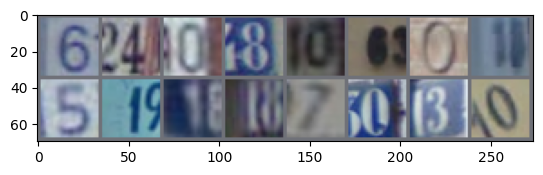

    6     4     0     8     0     6     0     1     5     1     1     1     7     0     3     0


In [75]:
# Assuming `images` is a torch tensor of shape (batch_size, channels, height, width)
# Assuming `trainloader` is your DataLoader object
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Model

In [76]:
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.init as init

## VAE

In [77]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        
        #Weight initialization
        init.xavier_normal_(self.conv.weight)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

In [78]:
class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [79]:
class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [80]:
class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        
        #self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)
        
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.xavier_normal_(self.linear.weight)
        

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

In [81]:
class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        #self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=1)
        

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)       #reshaped to have dimensions (batch_size, 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        
        #x = x.view(x.size(0), 3, 64, 64)
        x = x.view(x.size(0), 3, 32, 32)

        return x

In [82]:
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.mu = None
        self.logvar = None
        self.z = None

    def forward(self, x):
        self.mu, self.logvar = self.encoder(x)
        #z = self.reparameterize(mean, logvar)

        # sample z from q
        std = torch.exp(self.logvar / 2)
        q = torch.distributions.Normal(self.mu, std)
        self.z = q.rsample()
        
        x_recon = self.decoder(self.z)   
        
        return x_recon
    
    def gaussian_likelihood(self, x_hat, x, logscale):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss(self, x_hat, x):
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, x, self.log_scale)

        # kl
        std = torch.exp(self.logvar / 2)
        kl = self.kl_divergence(self.z, self.mu, std)

        # elbo
        #print(kl,recon_loss)
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return elbo
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

### Test

In [83]:
# Get a batch of images and labels
dataiter = iter(trainloader)
images, _ = next(dataiter)

# Forward pass through VAE model to obtain reconstructed images, mean, and log variance
vae_model_ins = VAE(z_dim=128)
recon_images = vae_model_ins(images)

# Compute VAE loss
loss = vae_model_ins.loss(recon_images, images)
# Print the loss

print("VAE Loss:", loss.item())

VAE Loss: 6239.17578125


## Block 2

In [84]:
class LatentMapper(nn.Module):
    def __init__(self, y_dim, z_dim, hidden_dims):
        super(LatentMapper, self).__init__()
        layers = []
        input_dim = y_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, z_dim))
        self.fc_layers = nn.Sequential(*layers)
        self.z_dim = z_dim
        self.z = torch.tensor([])
        
    def forward(self, y):
        self.z = self.fc_layers(y)
        return self.z

    def contrastive_loss(self, labels, margin=1.0, similarity='cosine'):
        # Compute pairwise similarity matrix
        if similarity == 'cosine':
            similarity_matrix = F.cosine_similarity(self.z.unsqueeze(1), self.z.unsqueeze(0), dim=-1)
        else:
            raise NotImplementedError("Other similarity metrics not implemented yet")

        # Create mask for positive and negative pairs
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
        mask.fill_diagonal_(0)  # Exclude diagonal elements (self-similarity)

        # Compute contrastive loss
        positive_pairs = similarity_matrix * mask
        negative_pairs = similarity_matrix * (1 - mask)
#         print('SIMILARITY MATRIX:\n',similarity_matrix)
#         print('MASK\n',mask)
        loss_contrastive = torch.mean((1 - positive_pairs) + torch.clamp(negative_pairs - margin, min=0))

        return loss_contrastive

In [85]:
lm_ins = LatentMapper(y_dim=128, z_dim=16, hidden_dims=[64, 32])
lm_ins

LatentMapper(
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
)

## NET

In [86]:
class NET(nn.Module):
    def __init__(self, vae, latent_mapper):
        super(NET, self).__init__()
        self.vae = vae
        self.latent_mapper = latent_mapper
        self.classifier = nn.Linear(self.latent_mapper.z_dim, 10)  # 10 is the number of classes
#         self.alpha = vae_loss_weight
#         self.beta = classification_loss_weight
#         self.gamma = contrastive_loss_weight
        
    def forward(self, x):
#         mu, logvar = self.vae.encode(x)
#         y = self.vae.reparameterize(mu, logvar)
        x_hat = self.vae(x)
        z = self.latent_mapper(self.vae.z)
        logits  = self.classifier(z)
        return x_hat, logits
    
    def loss(self, x_hat, x, logits, labels, alpha=1, beta=1, gamma=1):
        
        vae_loss = self.vae.loss(x_hat, x)
        classification_loss = nn.CrossEntropyLoss()(logits, labels)
        contrastive_loss = self.latent_mapper.contrastive_loss(labels)            
#         print(vae_loss , classification_loss, contrastive_loss)
        return  alpha * vae_loss + beta * classification_loss + gamma * contrastive_loss

### Test

In [87]:
# Get a batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

net_ins = NET(vae_model_ins, lm_ins)
recon_images, logits = net_ins(images)
# print(labels)
loss = net_ins.loss(recon_images, images, logits, labels)
# Print the loss
print("Loss:", loss.item())

Loss: 6260.9638671875


# Training

In [88]:
from tqdm.auto import tqdm

In [89]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [90]:
from torch.optim import Adam,SGD
from torch.optim.lr_scheduler import StepLR,ExponentialLR

In [91]:
def train(net, dataloader, EPOCHS, optimizer, scheduler, device, PATH, alpha=1, beta=100, gamma=500):
    
    epoch_losses=[np.nan]
    net.to(device);
    for epoch in range(EPOCHS): 
        net.train()
        running_loss = 0.0
        epoch_loss=0.0
        for i, data in tqdm(enumerate(dataloader, 0), desc="Training Progress"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            recon_images, logits = net(inputs)
            loss = net.loss(recon_images, inputs, logits, labels, alpha, beta, gamma)
            loss.backward()
            optimizer.step()


            # print statistics
            running_loss += loss.item() 
            epoch_loss += loss.item() 

            if i % 1000 == 999:    # print every 1000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] running loss: {running_loss / 1000:.1f}')
                running_loss = 0.0
        epoch_loss /= len(trainloader) * batch_size
        epoch_losses.append(epoch_loss) 
        print(f'Epoch {epoch + 1} loss: {epoch_loss:.3f}')
        scheduler.step()

    print()
    print('Training Finished...\n')
    
    torch.save(net.state_dict(), PATH)
    print('Model Saved as ', PATH)
    
    return epoch_losses

In [114]:
def plot_losses(loss_values, PATH):
    plt.figure(figsize=(16,6))
    plt.plot(loss_values,color='red')
    plt.xticks(np.arange(0, len(loss_values), step=1))
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch loss values during training')
    plt.savefig(PATH);

### VAE Training

In [93]:
# vae_model = VAE(z_dim=128)
# vae_model.to(device)

# optimizer = Adam(vae_model.parameters())
# scheduler = ExponentialLR(optimizer, gamma=0.99)

In [94]:
# EPOCHS=1
# loss_values=[np.nan]

# for epoch in range(EPOCHS): 
#     vae_model.train()
#     running_loss = 0.0
#     epoch_loss=0.0
#     for i, data in tqdm(enumerate(trainloader, 0), desc="Training Progress"):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         x_hat = vae_model(inputs)
#         loss = vae_model.loss(x_hat, inputs)
#         loss.backward()
#         optimizer.step()
        

#         # print statistics
#         running_loss += loss.item() 
#         epoch_loss += loss.item() 

#         if i % 1000 == 999:    # print every 1000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.1f}')
#             running_loss = 0.0
#     epoch_loss /= len(trainloader) * batch_size
#     loss_values.append(epoch_loss) 
#     print(f'Epoch {epoch + 1} loss: {epoch_loss:.3f}')
#     scheduler.step()
    
# print()
# print('Training Finished... ')

In [95]:
# PATH = './VAE_net.pth'
# torch.save(vae_model.state_dict(), PATH)

In [96]:
# vae_model1 = VAE(z_dim=128)
# vae_model1.load_state_dict(torch.load(PATH))

In [97]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)

# # print images
# imshow(torchvision.utils.make_grid(images))
# #print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [98]:
# outputs, _, _, _ = vae_model1(images)
# imshow(torchvision.utils.make_grid(outputs))

In [99]:
# loss_values

In [100]:
# plt.figure(figsize=(16,6))
# plt.plot(loss_values,color='red')
# plt.xticks(np.arange(0, EPOCHS+1, step=1))
# plt.grid()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Epoch loss values during training')
# plt.savefig('./VAE_losses_plot.png');

### NET initial training

In [101]:
vae = VAE(z_dim=128)
latent_mapper = LatentMapper(y_dim=128, z_dim=16, hidden_dims=[64, 32])
net = NET(vae, latent_mapper)

# vae.to(device)
# latent_mapper.to(device)
# net.to(device);

optimizer = Adam(net.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.99)

In [102]:
epoch_losses = train( net = net, 
                      dataloader = labeled_trainloader, 
                      EPOCHS = 2, 
                      optimizer = optimizer, 
                      scheduler = scheduler, 
                      device = device, 
                      PATH = './supervised_net.pth', 
                      alpha = 1, 
                      beta  = 100, 
                      gamma = 0
                    )

Training Progress: 0it [00:00, ?it/s]

Epoch 1 loss: 383.976


Training Progress: 0it [00:00, ?it/s]

Epoch 2 loss: 368.097

Training Finished...

Model Saved as  ./supervised_net.pth


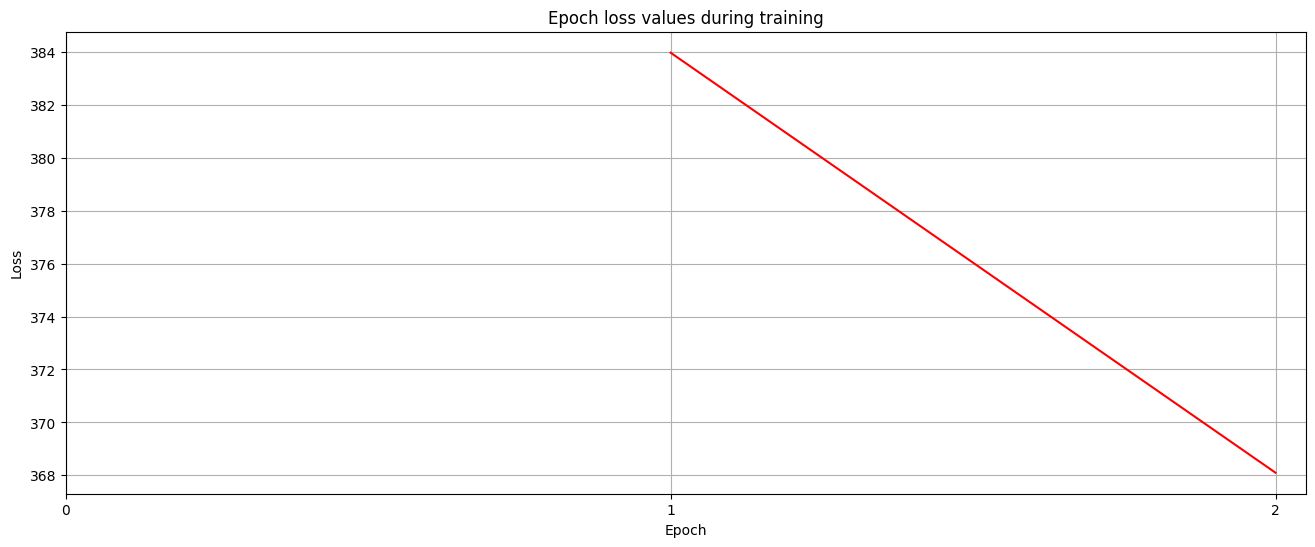

In [103]:
plot_losses(epoch_losses, PATH='./Classification_losses_plot.png')

### Create Pseudo labels

In [104]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [105]:
# Create pseudo-labeled dataset
pseudo_labeled_images = []
pseudo_labels = []

net.eval()
with torch.no_grad():
    for images, _ in tqdm(unlabeled_trainloader, desc="Unlabeled train set"):
        images = images.to(device)
        
        _, logits = net(images)
        predicted_labels = torch.argmax(logits, 1)
        
        pseudo_labeled_images.extend(images)
        pseudo_labels.extend(predicted_labels.tolist())

# Convert pseudo-labels to int
pseudo_labels = [int(label) for label in pseudo_labels]
pseudo_labeled_images = [sample.to('cpu') for sample in pseudo_labeled_images]


# Create pseudo-labeled dataset
pseudo_labeled_trainset = MyDataset(pseudo_labeled_images, pseudo_labels)

Unlabeled train set:   0%|          | 0/3663 [00:00<?, ?it/s]

In [106]:
# pseudo_loader = DataLoader(pseudo_labeled_trainset, batch_size=4, shuffle=False, num_workers=2)

#### Combining labeled & unlabeled

In [107]:
from torch.utils.data import ConcatDataset

# Combine labeled and pseudo-labeled datasets
combined_trainset = ConcatDataset([labeled_trainset, pseudo_labeled_trainset])

# Create DataLoader for combined dataset
combined_loader = DataLoader(combined_trainset, batch_size=16, shuffle=True, num_workers=2)

In [108]:
len(combined_trainset) == (len(labeled_trainset) + len(pseudo_labeled_trainset)) , len(full_trainset) == len(combined_trainset)

(True, True)

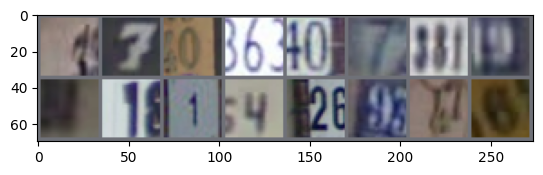

    1     1     1     1     1     1     1     9     1     1     1     1     1     1     1     1


In [109]:
dataiter = iter(combined_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [110]:
epoch_losses = train( net = net, 
                      dataloader = combined_loader, 
                      EPOCHS = 1, 
                      optimizer = optimizer, 
                      scheduler = scheduler, 
                      device = device, 
                      PATH = './semi_supervised_net.pth', 
                      alpha = 1, 
                      beta  = 10, 
                      gamma = 500
                    )

Training Progress: 0it [00:00, ?it/s]

[1,  1000] running loss: 5792.6
[1,  2000] running loss: 5771.7
[1,  3000] running loss: 5753.4
[1,  4000] running loss: 5740.2
Epoch 1 loss: 1800.475

Training Finished...

Model Saved as  ./semi_supervised_net.pth


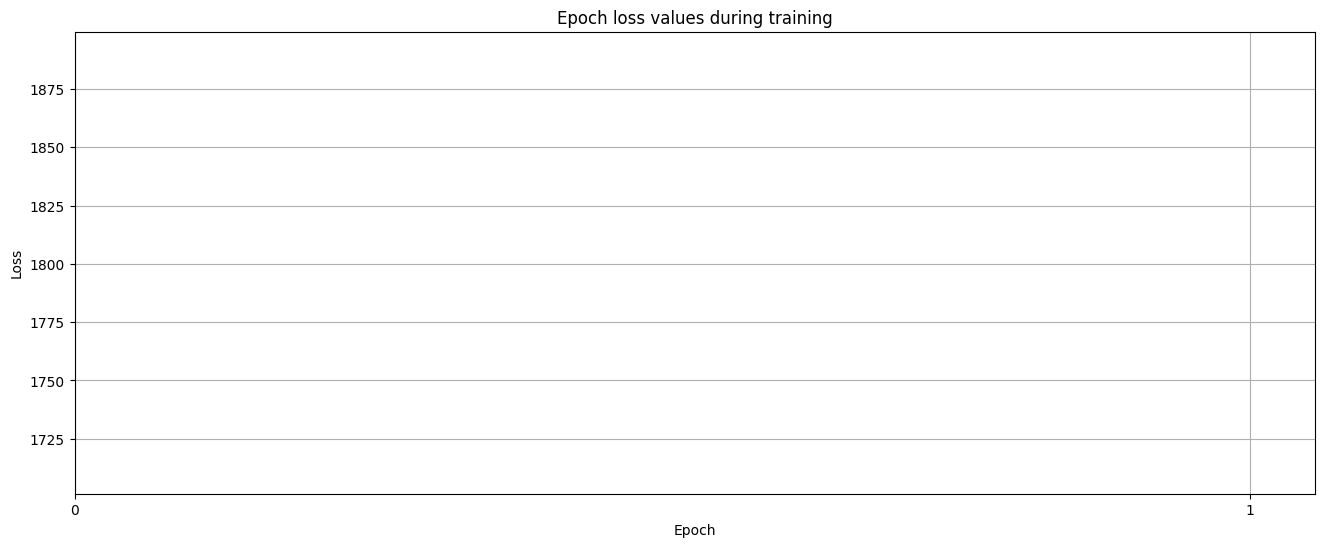

In [111]:
plot_losses(epoch_losses, PATH='./SS_losses_plot.png')

### Evaluation

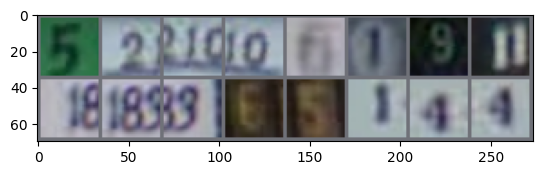

In [225]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [227]:
net.eval()
images = images.to(device)
labels = labels.to(device)

_, logits = net(images)
predicted = torch.argmax(logits, 1)
print('Preds:\n',predicted)
print('GTs:\n',labels)

Preds:
 tensor([5, 2, 1, 0, 0, 1, 9, 1, 1, 9, 9, 0, 5, 1, 4, 3], device='cuda:0')
GTs:
 tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4], device='cuda:0')


In [229]:
correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        _, logits = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)} test images: {100 * correct // total} %')

Accuracy of the network on the 1627 test images: 78 %
